<a href="https://colab.research.google.com/github/ArtemJDS/HTM/blob/main/HTM_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random as rn
import numpy as np

In [2]:
"""
Some helpfull functions which are used in the main body 
"""

def zeros_generate(l, lower, higher):
    """
    generates list of zeros with ones in it

    l - lenght of whole sequence
    lower - lower boundary of one's in sequence
    higher - higher boundary of one's in sequence
    """

    all_zeros = [0] * l

    final = [1 if n<higher and n>=lower else 0 for n,i in  enumerate(all_zeros)]
    return final


def create_connections(number_of_all_neurons,number_of_connections, mean_activation,set_to_zero):

      """
      returns connections between a neuron and number_of_connections of neurons with given number_of_all_neurons and 
      mean_activation - mean used in weights initiating 

      being used in both Neuron and Column classes

      """
      
      x = zeros_generate(number_of_all_neurons, 0 ,number_of_connections)

      y =[rn.uniform(mean_activation-(mean_activation/10), mean_activation+(mean_activation/10)) if n==1 else 0 for n in x]

      rn.shuffle(y)
      if set_to_zero!=None:
        y[set_to_zero]=0

      return y

def normalize_connections(connections, minimum):
  """
  After plasticity happened this function will be applied 

  minimum - lower bound of connection (if 0 - this conenction will be diminished)
  
  """

  connections = [1 if i>1 else minimum if i<0 else i for i in connections]

  return connections



def encoder(data: int,lenght: int, free_receptor: int,  limits: tuple =(0,99) ) -> list:

  """
  Creates simple input data - sequence of 0's and 1's 
  
  EXAMPLE: data is 7, limits are 0 and 9, every number is encoded using 2 ones with 1 overlapping

  [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

  """

  pot_values = limits[1]-limits[0]+1 #nmber of potential values integer can take

  n_of_receptors = lenght + (pot_values-1)*free_receptor

  least_rec = lenght*(data)-(lenght-free_receptor)*(data)

  code = zeros_generate(n_of_receptors,least_rec,least_rec+lenght )

  return code


def noising(input, noise_rate):
  """
  This function add noise to a given sequence of 0's and 1's
  noise_rate - is fraction of input's lenght
  """
  Nwrongneurons = int(np.round(len(input) * noise_rate))

  change = rn.sample([*range(len(input))],Nwrongneurons)
  input = [1 if (i==0 and input.index(i) in change) else 0 if i==1 and input.index(i) in change else i for i in input]
  return input
  

In [3]:
class Neuron:
  """
  active_neurons - list of active neurons on this stage
  previously_active_neurons - list of active neurons on the previous stage
  """ 
  ONneuron = 0 
  active_neurons = []

  def __init__(self,
               NNeurons,

               connection_fraction,
               neuron_activation_thrs,

               plasticity_const              
              ):
    
    """
    Initializes neuron with it's order_number

      creates connections between individual neurons
      NLateral_conn - number of all lateral connections
      lateral_connections - lateral connections [0,0.7,1,0] - neuron has no connections with 0'th and 3'th neurons and connections with 2'd and 3'd
      activity_state - every timestep is decided wheather this neuron is active (initilazed with False value)
      activity_couter - used in case if boosting is applied 
      neuron_activation_thrs - value of threshold of a connection activity
      plasticity_const - just a constant by which connections are changed
    """ 

    self.order_number = Neuron.ONneuron
    self.NLateral_conn = int(np.round(NNeurons*connection_fraction))
    self.lateral_connections = create_connections(NNeurons,self.NLateral_conn, neuron_activation_thrs, self.order_number)
    self.activity_state = False
    self.plasticity_const=plasticity_const
    self.activity_couter=0

    Neuron.ONneuron +=1


  def predictive_state(self, neuron_activation_thrs):

    """
    This function evaluets how many lateral neurons predict this neuron to fire
    """
    x=0
    for n,i in zip(self.lateral_connections,Neuron.active_neurons):
      if n>neuron_activation_thrs and i ==1:
        x+=1
    self.predicting = x

  def activation_neuron(self,neuron_activation_thrs):

    """
    This function checks if neuron is active and executes lateral plasticity
    """

    if self.activity_state == True:
      Neuron.active_neurons.append(1)

    else:
      Neuron.active_neurons.append(0)

    """
    The lateral plasticity happens here
    """

    if self.activity_state == True:

      self.lateral_connections = normalize_connections([i+self.plasticity_const if n==1 and i>0 else i-self.plasticity_const if n==0 and i>0 else 0 for n,i in zip(Neuron.previously_active_neurons,self.lateral_connections)],0)

    if self.lateral_connections.count(0)>len(self.lateral_connections)-self.NLateral_conn:
      zero_connections = [self.lateral_connections.index(i) for n,i in zip(Neuron.previously_active_neurons, self.lateral_connections) if i==0 and n==1]
      if len(zero_connections)!=0:
        to_create = rn.choice(zero_connections)
        self.lateral_connections[to_create] = neuron_activation_thrs


  def activity_trace(self, epoch, if_active):
    """
    This function evaluetes activity of neuron (used in boosting)
    """
    
    if if_active==True:
      self.activity_couter+=1
    self.activity_level = self.activity_couter/(epoch+1)



  @classmethod
  def set_list_of_active_to_zero(cls):
    """
    This function updates list of active_neurons and list of previously_active_neurons
    """

    cls.previously_active_neurons = cls.active_neurons
    cls.active_neurons = []
    









In [4]:
class Column: 

  ONColumn = 0
  preactivity_list = []

  def __init__(self,
               NNeurons,
               NNeurons_in,


               NReceptors,
               connection_fraction,
               column_activation_thrs,

               plasticity_const

               ):
    
      """  
      Initializes column with NNeurons_in neurons in one and with order_number

        NNeurons - number of all neurons (must be devidable by NNeurons_in)
        NReceptors - number of receptors (inputs)
        neurons_in_column - list of neurons (ord numbers of them) which belong to this column
        connection_fraction - fraction of receptors this column has connecitons to
        column_activation_thrs - value of threshold of connection activity  
        plasticity_const - just a constant by which connections are changed
        connections -  connecitons between column and receptors


      """

      if NNeurons%NNeurons_in!=0:
        raise Exception('Number of neurons is unacceptable. NNeurons must be devidable by NNeurons_in')
      if NNeurons<NNeurons_in:
        raise Exception('Number of neurons is unacceptable. NNeurons must be greater than NNeurons_in')

      self.order_number = Column.ONColumn
      self.neurons_in_column = [*range(NNeurons)][Column.ONColumn*NNeurons_in:NNeurons_in*(Column.ONColumn+1)]
      NСonnections = int(np.round(NReceptors*connection_fraction))
      self.column_activation_thrs = column_activation_thrs
      self.plasticity_const = plasticity_const
      self.connections = create_connections(NReceptors,NСonnections, self.column_activation_thrs, None)

      Column.ONColumn+=1

  def preactivation(self, input):

        """
        This function calculates number of inputs to the column 

        This number is  passed then to "column competition" via  Column.preactivity_list and after all columns contributed column_competition() decides which columns are to be activated
        """
        
        Ninput = 0


        for n,i in zip(self.connections, input):
          if n>=self.column_activation_thrs and i==1:
            Ninput=+1

        self.for_plasticity = [1 if n>=0 and i==1 else -1 if n>=0 and i==0 else 0 for n,i in zip(self.connections, input)]

        Column.preactivity_list.append(Ninput)


      

  @classmethod
  def column_competition(cls, fraction_of_winners):

        """
        This function decides which columns are to be activated (uses fraction of top columns)

        After execution preactivity_list is set to []
        """

        cls.winner_columns = []

        Nactivated = int(np.round(len(cls.preactivity_list)*fraction_of_winners))

        if len(set(cls.preactivity_list))>1:
          values_of_columns = [(i,n) for n,i in enumerate(cls.preactivity_list)]
          rn.shuffle(values_of_columns)
          cls.winner_columns = [x[1] for x in sorted(values_of_columns, key = lambda x: x[0])[-Nactivated:]]
        else:

          cls.winner_columns = rn.sample([*range(len(cls.preactivity_list))],Nactivated)

        cls.preactivity_list = []


  def column_activation(self, lateral_activation_thrs, list_of_neurons ): 

    """
    This function activates neurons in active columns (from winner_columns)

      if there are neurons which are predicted (if numb of active conenctions is more than lateral_activation_thrs) these neurons are activated
      if there are neurons which are predicted (but numb of active conenctions is less than lateral_activation_thrs) only one neuron (with largest number of active conenctions) is activated
      otherwise column bursts

    Also plasticity of receptors connections happens
    """
    

    if self.order_number in Column.winner_columns:

      """
      Here activation of neurons happens
      """
      lateral_input = [i.predicting for i in list_of_neurons if i.order_number in self.neurons_in_column]


      if len(set(lateral_input))>1:  

        if max(lateral_input)>=lateral_activation_thrs:
          # in this case all cell that have connections more than thrs will be activated

          neurons_activated = [1 if i >= lateral_activation_thrs else 0 for i in lateral_input ] 

        if len(set(lateral_input))>1 and max(lateral_input)<lateral_activation_thrs: 

          neurons_activated = [1 if i==max(lateral_input) else 0 for i in lateral_input]

      if len(set(lateral_input))<=1:
        neurons_activated = [1 for i in lateral_input]


      for n,i in zip(neurons_activated, self.neurons_in_column):
        if  n ==1: list_of_neurons[i].activity_state = True 

        elif list_of_neurons[i].activity_level<0.1 and rn.random()<0.05: list_of_neurons[i].activity_state = True
           
        else: list_of_neurons[i].activity_state = False
      

      """
      Here plasticity of receptors happens
      """

      self.connections =normalize_connections([i+self.plasticity_const if n==1 else i-self.plasticity_const if n==-1 else 0 for n,i in zip(self.for_plasticity,self.connections)],0)
    else:

      for i in self.neurons_in_column:
        list_of_neurons[i].activity_state = False


  

In [5]:
"""
Those must be specified:
  epoches - number of epoches 
  n_of_neurons - number of neurons 
  n_in_one_column - number of neurons in one column
  neuron_thrs - neuron threshold
  neurom_conn_fr - connection fraction of neuron
  prediction_thrs - threshold for a neuron to become predicted
  noise_fr - fraction of noise in input
"""

epoches = 5000
n_of_neurons =1024
n_in_one_column=8
neuron_thrs = 0.5
neurom_conn_fr = 0.05
prediction_thrs = int(neurom_conn_fr*n_of_neurons/10)
noise_fr = 0.05


"""
Here data is created
This block of code is unnecessary
"""

#############################
data=[]
s=9
x = 0 
for i in range(int(epoches/5)):

  data.append(noising([encoder(data = x, lenght= 10, free_receptor = 7,limits= (0,s) ),x][0],noise_fr))
  if x!=s: x +=1
  else: x = 0 
x=s
for i in range(int(epoches/5)):

  data.append(noising([encoder(data = x, lenght= 10, free_receptor = 7,limits= (0,s) ),x][0],noise_fr))
  if x!=0: x -=1
  else: x = s

x=0
for i in range(int(epoches/5)):

  data.append(noising([encoder(data = x, lenght= 10, free_receptor = 7,limits= (0,s) ),x][0],noise_fr))
  if x!=s: x +=1
  else: x = 0
#############################

"""
Here neurons and columns are initiated
Some vatiables are specified to run the programm
"""

list_of_neurons = [Neuron(n_of_neurons,neurom_conn_fr, neuron_thrs, 0.05,) for i in range(n_of_neurons)]
list_of_columns = [Column(n_of_neurons,n_in_one_column,len(data[0]), 0.7,0.5,0.05,) for i in range(int(n_of_neurons/n_in_one_column))]
Neuron.active_neurons=[0 for _ in range(n_of_neurons)]
Neuron.previously_active_neurons=[0 for _ in range(n_of_neurons)]

"""
Here variables for the future analysis are initiated
"""
d=[]



"""
Here the simulation starts
"""

for r,input in enumerate(data):
  list_of_pred = []

  for i in list_of_neurons:
    i.predictive_state(neuron_thrs)
    list_of_pred.append(i.predicting)
  for i in list_of_columns:

    i.preactivation(input)

  Column.column_competition(0.1)

  for i in list_of_columns:
    i.column_activation(prediction_thrs, list_of_neurons)
 
  Neuron.set_list_of_active_to_zero()

  for i in list_of_neurons:
    i.activation_neuron(neuron_thrs)
    i.activity_trace(r,i.activity_state)


  d.append((list_of_pred,Neuron.active_neurons))
  print(r)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

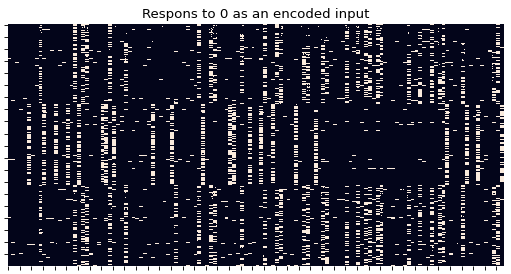

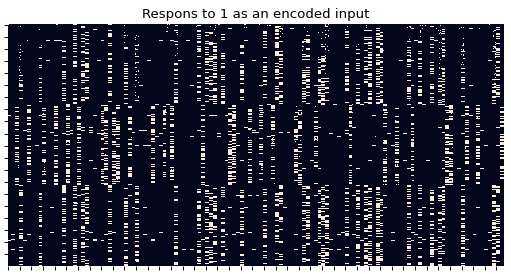

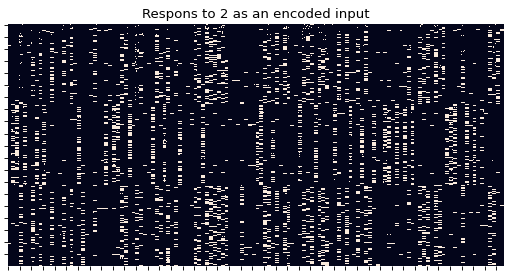

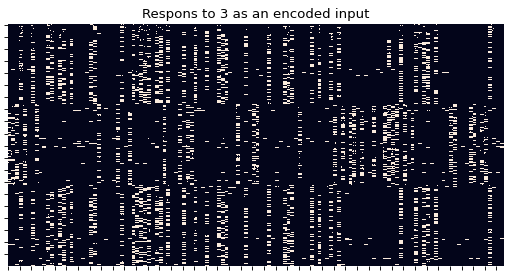

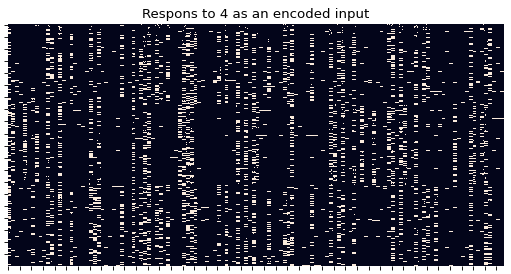

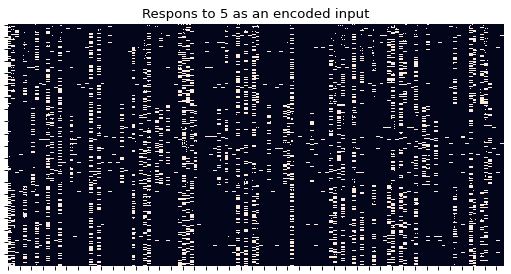

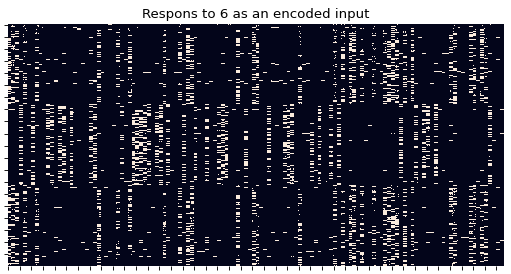

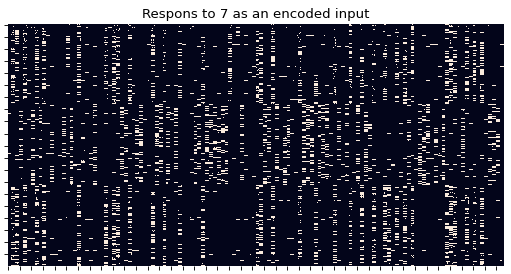

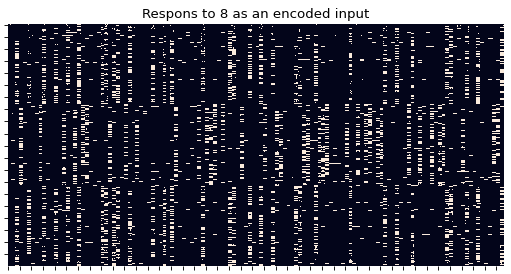

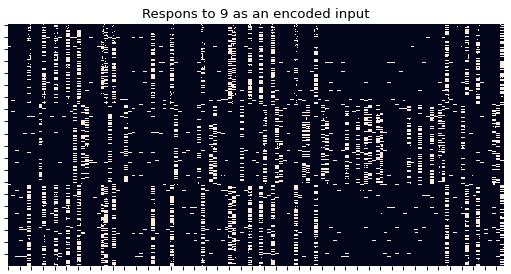

In [6]:
"""
How the system activates in response to different data

On a plot 
  every row is a sequence list 0's and 1's (1's - active cells)
  time goes from above to bottom

"""

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pyplot import figure

for i in range(10):
  figure(figsize=(8,4), dpi=80)
  ax = sns.heatmap([i[1] for i in d[i::10]],cbar=False)
  ax.set(xticklabels=[])
  ax.set(yticklabels=[])
  ax.set(xlabel=None)
  ax.set(ylabel=None)
  plt.title('Respons to {} as an encoded input'.format(i))

plt.show()